In [1]:
!pip install networkx matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import torch
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

/home/girishkk/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 1: Data Preprocessing and Label Encoding
def df_label_encoder(df, columns):
    le = preprocessing.LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [4]:
# Preprocess the dataset and extract features for node creation
def preprocess(df):
    # Encode categorical columns
    df = df_label_encoder(df, ['merchant', 'category', 'city', 'state', 'job'])

    # Normalize the 'amt' and other numeric columns
    df['amt'] = (df['amt'] - df['amt'].min()) / (df['amt'].max() - df['amt'].min())

    # Combine columns to create unique identifiers for nodes
    df['node_from'] = df['cc_num'].astype(str)  # Treat credit card numbers as nodes
    df['node_to'] = df['merchant'].astype(str)  # Merchants as another set of nodes

    # Sort values by 'node_from' for consistency
    df = df.sort_values(by=['node_from'])

    # Create a list of unique nodes (accounts/merchants)
    node_list = pd.concat([df['node_from'], df['node_to']]).unique()

    return df, node_list

In [5]:
# Step 2: Create Graph Data Without torch_geometric
def create_graph_data(df, node_list):
    # Create a mapping of node names to indices
    node_map = {node: idx for idx, node in enumerate(node_list)}

    # Convert edges to indices
    edge_index = np.array([
        [node_map[from_node], node_map[to_node]] for from_node, to_node in zip(df['node_from'], df['node_to'])
    ], dtype=np.int64).T

    # Node features (converted to numpy array or tensor)
    node_features = torch.tensor(df[['amt', 'category', 'city', 'state']].values, dtype=torch.float)

    # Labels (0 for non-fraud, 1 for fraud)
    labels = torch.tensor(df['is_fraud'].values, dtype=torch.long)

    return node_features, edge_index, labels

In [6]:
# Load dataset and preprocess
df = pd.read_csv('creditcard/fraudTrain.csv')  # Update with your .csv file path
df, node_list = preprocess(df)

In [7]:
# Create the graph dataset
node_features, edge_index, labels = create_graph_data(df, node_list)

In [8]:
def plot_class_distribution(y_data, title):
    classes, counts = torch.unique(y_data, return_counts=True)
    plt.bar(classes.numpy(), counts.numpy())
    plt.title(title)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
    plt.show()

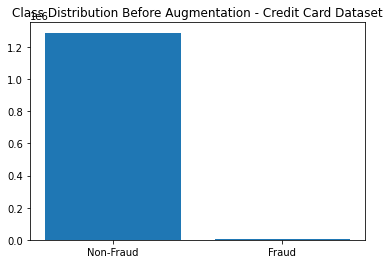

In [9]:
# Plot initial class distribution
plot_class_distribution(labels, "Class Distribution Before Augmentation - Credit Card Dataset")

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(z))

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [11]:
# GAN parameters
input_size = node_features.shape[1]  # Number of node features
hidden_size = 128
output_size = input_size  # Output size matches input for node features
latent_size = 64

In [12]:
# Initialize GAN components
generator = Generator(latent_size, hidden_size, output_size)
discriminator = Discriminator(input_size, hidden_size)

In [13]:
# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [14]:
# Function to compute statistics: mean, variance, and standard deviation
def compute_statistics(features):
    mean = torch.mean(features, dim=0)
    var = torch.var(features, dim=0)
    std = torch.std(features, dim=0)
    return mean, var, std

In [15]:
# Print initial statistics
initial_mean, initial_var, initial_std = compute_statistics(node_features)
print(f"Initial Mean: {initial_mean}, Initial Variance: {initial_var}, Initial Std Dev: {initial_std}")

Initial Mean: tensor([2.3957e-03, 6.2278e+00, 4.4526e+02, 2.6677e+01]), Initial Variance: tensor([3.0670e-05, 1.5315e+01, 6.6874e+04, 2.0538e+02]), Initial Std Dev: tensor([5.5381e-03, 3.9134e+00, 2.5860e+02, 1.4331e+01])


In [16]:
num_epochs = 10
target_minority_class = torch.sum(labels == 0)  # We want to match the majority class count
real_data = node_features[labels == 1]  # Fraud samples (minority class)

In [17]:
for epoch in range(num_epochs):
    # Update current minority count during each epoch to reflect balancing progress
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break  # Stop training when the minority class is balanced

    # Sample noise for generator input
    z = torch.randn(real_data.size(0), latent_size)

    # Generate fake data
    fake_data = generator(z)

    # Train Discriminator
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data.detach())
    loss_d = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    # Train Generator
    d_fake = discriminator(fake_data)
    loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Update your labels based on newly generated samples (for example, appending new data)
    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    node_features = torch.cat((node_features, fake_data))

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

Epoch [0/10], Loss D: 38.289794921875, Loss G: 0.6087443828582764
Epoch [1/10], Loss D: 28.794511795043945, Loss G: 0.606468915939331
Epoch [2/10], Loss D: 19.58536148071289, Loss G: 0.6048112511634827
Epoch [3/10], Loss D: 10.982868194580078, Loss G: 0.602719247341156
Epoch [4/10], Loss D: 3.844224214553833, Loss G: 0.6006903648376465
Epoch [5/10], Loss D: 0.8552053570747375, Loss G: 0.5999202728271484
Epoch [6/10], Loss D: 0.7997614741325378, Loss G: 0.6003209352493286
Epoch [7/10], Loss D: 0.798646867275238, Loss G: 0.6012616753578186
Epoch [8/10], Loss D: 0.7967071533203125, Loss G: 0.6033711433410645
Epoch [9/10], Loss D: 0.7944555878639221, Loss G: 0.6057661771774292


In [18]:
# Generate enough samples to match the class distribution
num_generated_samples = target_minority_class - current_minority_count
generated_data = generator(torch.randn(num_generated_samples, latent_size))  # Generate samples
y_generated = torch.ones(num_generated_samples, dtype=torch.long)  # Label these as fraudulent (minority class)

In [19]:
# Combine generated data with the original data
x_augmented = torch.cat([node_features, generated_data], dim=0)
y_augmented = torch.cat([labels, y_generated], dim=0)

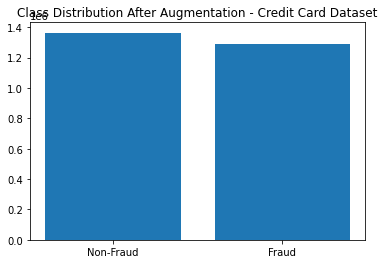

In [20]:
# Plot augmented class distribution
plot_class_distribution(y_augmented, "Class Distribution After Augmentation - Credit Card Dataset")

In [21]:
# Print final statistics
final_mean, final_var, final_std = compute_statistics(x_augmented)
print(f"Final Mean: {final_mean}, Final Variance: {final_var}, Final Std Dev: {final_std}")

Final Mean: tensor([  0.2987,   3.3426, 217.8891,  13.3592], grad_fn=<MeanBackward1>), Final Variance: tensor([8.5516e-02, 1.5441e+01, 8.2091e+04, 2.6989e+02],
       grad_fn=<VarBackward0>), Final Std Dev: tensor([  0.2924,   3.9295, 286.5156,  16.4282], grad_fn=<StdBackward0>)


In [22]:
# Assuming real_data is your actual node features labeled as fraud (real minority class)
real_data = node_features[labels == 1]  # Take only fraud samples (minority class)

# If generated_data has more samples than real_data, we need to match their size
min_size = min(real_data.size(0), generated_data.size(0))

# Subsample real and generated data to have the same number of rows
real_data_sampled = real_data[:min_size]
generated_data_sampled = generated_data[:min_size]

# Function to compute R-squared
def r_squared(real_data, generated_data):
    ss_res = torch.sum((real_data - generated_data) ** 2, dim=0)  # Residual sum of squares
    ss_tot = torch.sum((real_data - torch.mean(real_data, dim=0)) ** 2, dim=0)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [23]:
# Compute R-squared between the real and generated data samples
r2_scores = r_squared(real_data_sampled, generated_data_sampled)
print(f"R-squared for each feature: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean()}")

R-squared for each feature: tensor([-1774.8032,    -3.1311,    -2.8761,    -3.4169],
       grad_fn=<RsubBackward1>)
Mean R-squared: -446.0568542480469


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_augmented, y_augmented, test_size=0.3, random_state=42)

# Define a simple classifier (e.g., a neural network) for demonstration
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size=node_features.shape[1], hidden_size=64)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the classifier and track metrics
epochs = 50
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    current_minority_count = torch.sum(labels == 1)
    if current_minority_count >= target_minority_class:
        break

    # Generate fake data
    z = torch.randn(real_data.size(0), latent_size)
    fake_data = generator(z)

    # Train Discriminator
    optimizer_d.zero_grad()
    d_real = discriminator(real_data)
    d_fake = discriminator(fake_data.detach())  # Detach to prevent backprop through the generator
    loss_d = loss_fn(d_real, torch.ones_like(d_real)) + loss_fn(d_fake, torch.zeros_like(d_fake))
    loss_d.backward()  # Backprop for discriminator
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    d_fake = discriminator(fake_data)  # Fresh forward pass for generator
    loss_g = loss_fn(d_fake, torch.ones_like(d_fake))
    loss_g.backward(retain_graph=True)  # Retain graph if needed for further generator computations
    optimizer_g.step()

    labels = torch.cat((labels, torch.zeros(fake_data.size(0), dtype=torch.long)))
    node_features = torch.cat((node_features, fake_data))

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')


# Plotting Training and Testing Losses
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Testing Accuracies
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred.detach().numpy())
roc_auc = roc_auc_score(y_test, y_test_pred.detach().numpy())

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix
y_pred_classes = y_test_pred.round().detach().numpy()
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print final AUC score and accuracy
print(f"Final Test ROC AUC Score: {roc_auc:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.